In [25]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters (B.subtilis - minimal media)

In [26]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [27]:
import warnings
warnings.filterwarnings("ignore")

## Preprocessing
### Read data

In [28]:
data_path = "../../data/probe_Bac_scRNAseq_Rosenthal/B subtilis minimal media"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")


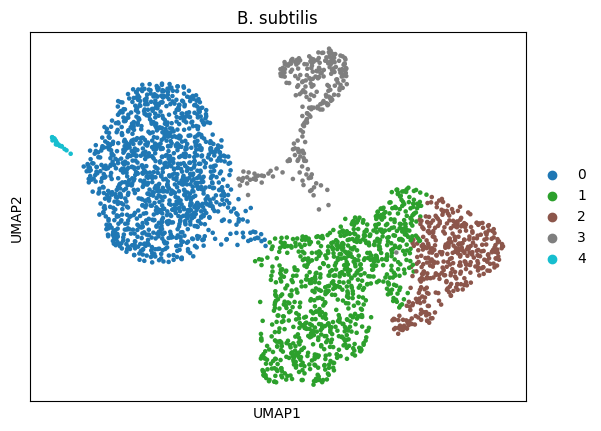

In [29]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="B. subtilis")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [30]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 200
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 400
Both NB and ZINB not converged! Using NB withou

In [31]:
data_gene.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,...,Protein accession,Name,Symbol,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
index,,,,,,,,,,,,,,,,,,,,,
Sr1,Gene Expression,PA01,30,0.012931,0.012848,98.922414,36.0,3.610918,30,0.017074,...,NaN,NaN,NaN,0.012931,0.017074,-0.004143,nb,0.012927,0.031389,0.0
aadK,Gene Expression,PA01,163,0.065733,0.063663,94.145115,183.0,5.214936,163,0.077217,...,NP_390556.1,aminoglycoside 6-adenylyltransferase,aadK,0.065733,0.077217,-0.011484,nb,0.065737,0.358580,0.0
aag,Gene Expression,PA01,15,0.006106,0.006088,99.461207,17.0,2.890372,15,0.007506,...,NP_391741.1,3-alkylated purines and hypoxanthine DNA glyco...,aag,0.006106,0.007506,-0.001399,nb,0.006101,0.022522,0.0
aapA,Gene Expression,PA01,273,0.108118,0.102663,90.193966,301.0,5.710427,273,0.117262,...,NP_390587.2,small amino acid permease,aapA,0.108118,0.117262,-0.009144,nb,0.108118,1.176949,0.0
abbA,Gene Expression,PA01,308,0.133980,0.125733,88.936782,373.0,5.924256,308,0.173501,...,NP_389295.1,regulator of AbrB repressor,abbA,0.133980,0.173501,-0.039521,nb,0.133983,0.451536,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znuB,Gene Expression,PA01,106,0.042026,0.041167,96.192529,117.0,4.770685,106,0.048162,...,NP_388169.1,high affinity Zn(II) ABC transporter (permease),znuB,0.042026,0.048162,-0.006136,nb,0.042036,0.251568,0.0
znuC,Gene Expression,PA01,33,0.013649,0.013557,98.814655,38.0,3.663562,33,0.017773,...,NP_388168.1,Zn(II) transporter (ATP-binding protein),znuC,0.013649,0.017773,-0.004124,nb,0.013660,0.044729,0.0
zosA,Gene Expression,PA01,36,0.015805,0.015681,98.706897,44.0,3.806662,36,0.022020,...,NaN,NaN,NaN,0.015805,0.022020,-0.006216,nb,0.015804,0.034633,0.0


## Find optimal correlation matrix scaling and generate synthetic null data

In [32]:
importlib.reload(cd)
xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
print(xmin)

Factor: 1 - Error: 61.062145526926074
Factor: 2 - Error: 41.61230366138131
Factor: 3.6180339999999998 - Error: 47.5639997000499
Factor: 2 - Error: 41.61230366138131
Factor: 2.61803399102434 - Error: 42.6728986049149
Factor: 1.61803399 - Error: 41.928476205147085
Factor: 2.236067977595943 - Error: 41.5709760988543
Factor: 2.3819660117007944 - Error: 42.03119452115826
Factor: 2.1458980341048512 - Error: 41.553153060038696
Factor: 2.0901699441509773 - Error: 41.50337615883041
Factor: 2.055728090361706 - Error: 41.58788587302456
Factor: 2.11145618031558 - Error: 41.759568018114386
Factor: 2.077014326682086 - Error: 41.63394466492494
Factor: 2.0983005628466884 - Error: 41.846903049848464
Factor: 2.085144945437299 - Error: 41.685404726106
Factor: 2.0932755641330094 - Error: 41.53792009143197
Factor: 2.0882505654420584 - Error: 41.40961663161148
Factor: 2.087064324160264 - Error: 41.461600318279295
Factor: 2.088983702869183 - Error: 41.479646030872075
Factor: 2.0877974615927544 - Error: 41.53

In [33]:
importlib.reload(cd)

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [34]:
importlib.reload(cd)
n, p = data_gene.X.shape
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, new_data_shape=(2*n, p),
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)


In [35]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [36]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

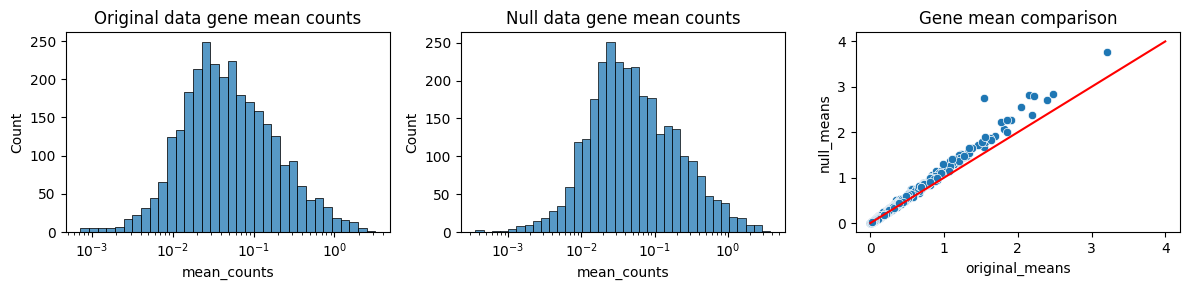

SignificanceResult(statistic=0.9974085258623435, pvalue=0.0)


In [37]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

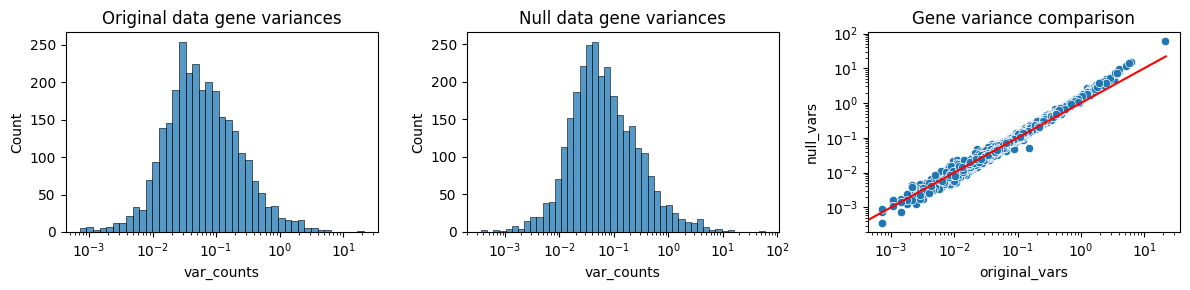

SignificanceResult(statistic=0.9945072531930294, pvalue=0.0)
[[1.         0.97488478]
 [0.97488478 1.        ]]


In [38]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

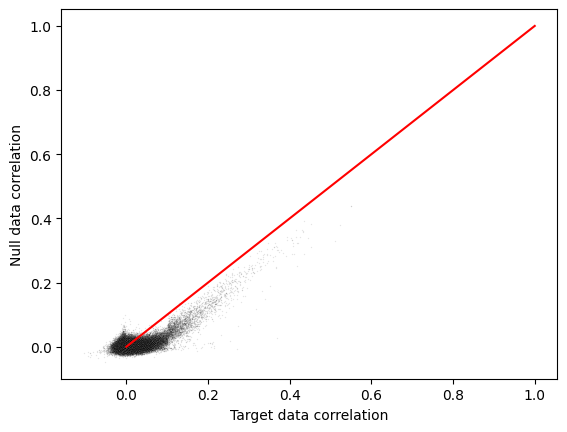

In [39]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [40]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [41]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform")
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]
print(n_neighbors_opt)

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


20


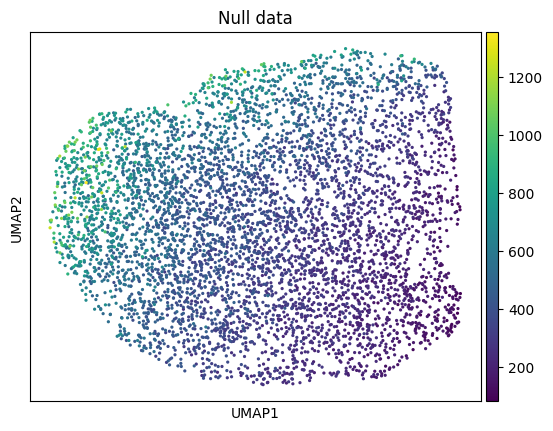

In [42]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [43]:
data_null_gen.write(data_path + "/null_data_opt.h5ad")

In [44]:
data_null_gen = sc.read_h5ad(data_path + "/null_data_opt.h5ad")
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

In [45]:
n_splits = 1
rng = np.random.default_rng(2345)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01
res_step = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    nclust = 1
    was_greater = False
    max_res_1_cluster = 0
    
    while twoclust is False:
        if nclust < 2:
            if res2 > max_res_1_cluster:
                max_res_1_cluster = res2
            elif max_res_1_cluster > 0: 
                res_step = res_step / 2
            if was_greater:
                res2 += res_step
            else:
                res2 += res_step * 5
        else:
            was_greater = True
            min_res_2plus_clusters = res2
            res2 -= res_step
        res2 = np.round(res2, 5)
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        if nclust == 2:
            twoclust = True
        print(f"resolution: {res2}, clusters: {nclust}, step: {res_step}")
            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 0.05
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(f"Best split: No. {best_split} - seed: {seeds[best_split]} - minimal p-value: {min_pvals_null[best_split]}")

resolution: 0.06, clusters: 1, step: 0.01
resolution: 0.11, clusters: 2, step: 0.01
split 1/1 - Resolution 0.11
Best split: No. 0 - seed: 111 - minimal p-value: 6.577817221177584e-277


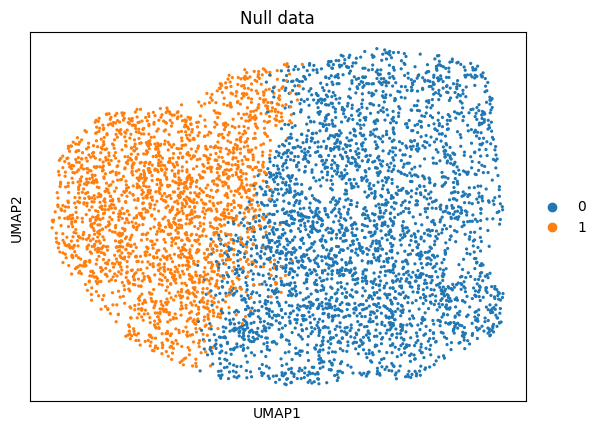

In [46]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [47]:
data_null_gen.obs["leiden_best"] = data_null_gen.obs[f"leiden_{best_split}"]

data_null_gen.write(data_path + "/null_data_opt.h5ad")

In [48]:
data_null_gen = sc.read_h5ad(data_path + "/null_data_opt.h5ad")

In [49]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05
rng = np.random.default_rng(1234)

for c in clusters:
    
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    
    n_cells_0 = X_data_0.shape[0]
    n_cells_1 = X_data_1.shape[0]
    
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] != "0"]
    X_null_gen_0 = X_null_gen_0[rng.integers(X_null_gen_0.shape[0], size=n_cells_0),:]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] == "0"]
    X_null_gen_1 = X_null_gen_1[rng.integers(X_null_gen_1.shape[0], size=n_cells_1),:]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.05964912280701754
Cluster 2 - DE genes: 0; Minimum q value: 0.25790754257907544
Cluster 3 - DE genes: 47; Minimum q value: 0.02702702702702703
Cluster 1 - DE genes: 0; Minimum q value: 0.14801864801864803
Cluster 4 - DE genes: 28; Minimum q value: 0.03571428571428571


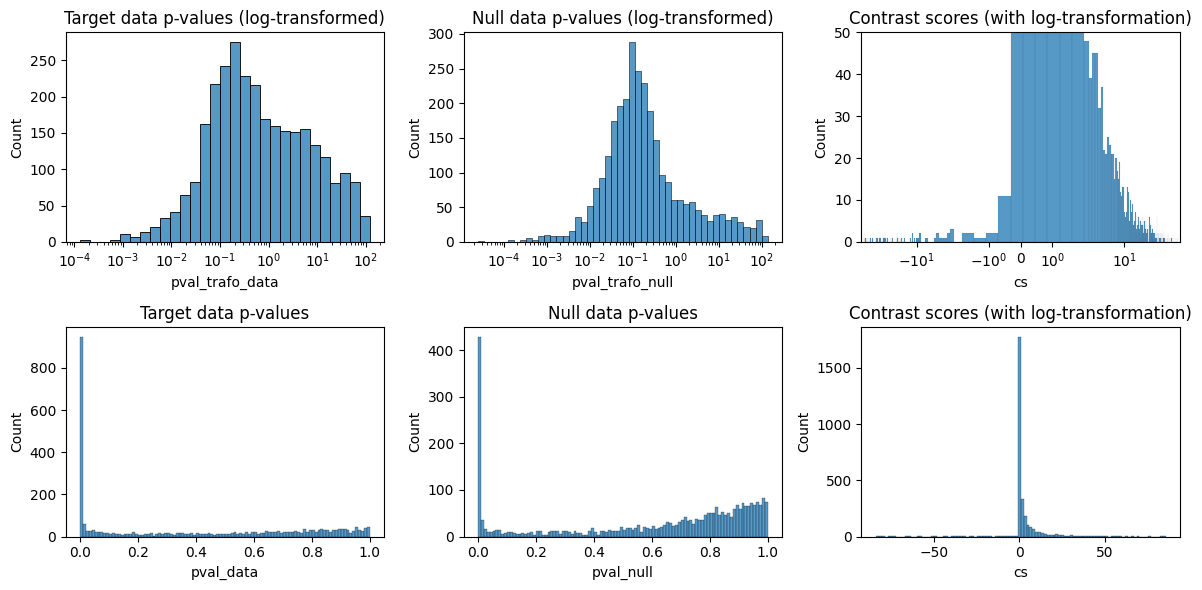

In [50]:
c = "0"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [51]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 0
0.059649    1425
0.060014       8
0.060166      13
0.060648       5
0.061126       5
            ... 
0.248614       3
0.252237       2
0.252551       5
0.253294       1
1.000000     598
Name: q, Length: 294, dtype: int64

cluster 2
0.257908     822
0.259172      23
0.259560      18
0.262014      11
0.262202       7
            ... 
0.517098       1
0.517598       2
0.518079       4
0.520640       2
1.000000    1013
Name: q, Length: 309, dtype: int64

cluster 3
0.027027      37
0.042553      10
0.061224       2
0.080000       1
0.294118       1
            ... 
0.852718       3
0.852811       1
0.854798       1
0.855612       2
1.000000    1365
Name: q, Length: 82, dtype: int64

cluster 1
0.148019    858
0.148664      3
0.149133      4
0.150229      7
0.150547    317
           ... 
0.353321      4
0.353754      3
0.354349      2
0.355106      1
1.000000    777
Name: q, Length: 318, dtype: int64

cluster 4
0.035714      28
0.058824       6
0.105263       4
0.128205       1
0.

In [52]:
pvals_log_gen["4"].sort_values("pval_null")

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
index,,,,,,
dhbF,0.097525,6.683126e-07,1.010882,6.175020,-5.164138,1.000000
rpsL,0.143791,1.162710e-06,0.842269,5.934529,-5.092260,1.000000
dhbE,0.063788,1.489701e-06,1.195259,5.826901,-4.631642,1.000000
rplW,0.067659,1.933390e-06,1.169677,5.713681,-4.544004,1.000000
rplQ,0.925374,3.051896e-06,0.033683,5.515430,-5.481747,1.000000
...,...,...,...,...,...,...
pksB,0.936026,9.982179e-01,0.028712,0.000775,0.027938,0.544985
yrrC,0.992538,9.985521e-01,0.003253,0.000629,0.002624,0.625954
yhcW,0.948134,9.997772e-01,0.023130,0.000097,0.023034,0.561953


In [53]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [54]:
data_gene_nonzero.write(data_path + "/filtered_data_maxpool_processed_cluster.h5ad")

In [55]:
data_gene_nonzero = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed_cluster.h5ad")
